In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
import tensorflow_probability as tfp
import matplotlib.pylab as plt

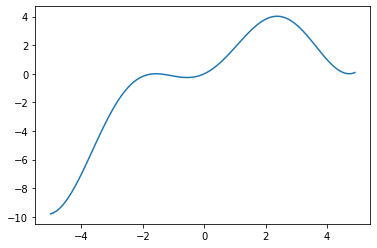

In [2]:
# Lets create some data

x = np.arange(-5,5, 0.1)
y = x+ x*np.sin(x)
plt.plot(x,y)

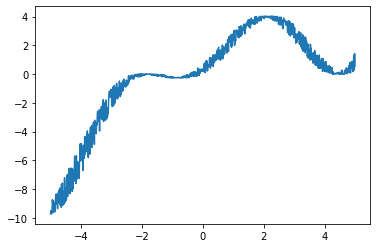

In [4]:
# but real data is never so perfect
# Lets add some noise

random_error = 0.5*np.random.rand(1000).reshape(1000,1)
x = np.arange(-5,5, 0.01).reshape(1000,1)
x_error = x+random_error

y=x_error+ x_error*np.sin(x_error)

#y = ((x+random_error)*np.sin(x+random_error)).reshape(1000,1)
plt.plot(x,y)

In [72]:
# We need to define some distribution for our model

class Gaussian(object):
    def __init__(self, mu, **kwargs):
        
        
        self.mu = mu
        #sigma = log(1+e^rho)
        rho = kwargs.get("rho", None)
        sigma = kwargs.get("sigma", None)

        if (rho is None) and (sigma is None):
            assert "None of rho or sigma is specified"
        elif rho is None:
            self.sigma = sigma
            self.rho = tf.math.log(tf.math.exp(self.sigma)-1)
        elif sigma is None:
            self.rho = rho
            self.sigma = tf.math.log(1+ tf.math.exp(self.rho))
            
            
    def sample(self):   
        epsilon = tf.random.normal(shape = self.mu.shape)
        sample = self.mu+self.sigma*epsilon
        return sample

    def log_prob(self,x):
        
        log_prob = tf.reduce_sum(tfp.distributions.Normal(loc = self.mu, scale = self.sigma).log_prob(x))
        
        return log_prob
    
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma_1, sigma_2):
        self.pi = pi
        self.sigma_1 = sigma_1
        self.sigma_2 = sigma_2
        self.gaussian_1 = Gaussian(mu = 0.0, sigma = sigma_1)
        self.gaussian_2 = Gaussian(mu = 0.0, sigma = sigma_2)

    def log_prob(self,x):
        prob_1 = tf.clip_by_value(tf.math.exp(self.gaussian_1.log_prob(x)), clip_value_min= 1e-10, clip_value_max= 1.)
        prob_2 = tf.clip_by_value(tf.math.exp(self.gaussian_2.log_prob(x)), clip_value_min = 1e-10, clip_value_max = 1.)
        
        return tf.math.log(self.pi*prob_1+(1-self.pi)*prob_2)

In [73]:
# Now lets create our Bayesian Layer

class BayesianDense(Layer):
    def __init__(self, units = 4, activation = None, **kwargs):
        super(BayesianDense, self).__init__(**kwargs)
        self.units = units
        prior_pi = 0.5
        prior_sigma_1 = tf.math.exp(1.0)
        prior_sigma_2 = tf.math.exp(-1.0)
        
        self.activation = tf.keras.activations.get(activation)
        
        self.prior = ScaleMixtureGaussian(prior_pi, prior_sigma_1, prior_sigma_2)
                
        self.log_prior = 0
        self.log_posterior = 0
                
    def build(self, input_shape):
        
        w_init = tf.random_uniform_initializer(-2.0, 2.0)
        b_init = tf.zeros_initializer()
        self.w_mu = tf.Variable(name='w_mu',
                               initial_value= w_init(shape=(input_shape[-1], self.units),
                                                    dtype = 'float32'), trainable = True)
        self.w_rho = tf.Variable(name='w_rho',
                                 initial_value= w_init(shape=(input_shape[-1], self.units),
                                                    dtype = 'float32'), trainable = True)
        self.b_mu = tf.Variable(name='b_mu',
                               initial_value= b_init(shape=(self.units,),
                                                    dtype = 'float32'), trainable = True)
        
        self.b_rho = tf.Variable(name='b_rho',
                               initial_value= b_init(shape=(self.units,),
                                                    dtype = 'float32'), trainable = True)
        
        
    def call(self, inputs, training=None):
        '''This is where all the computation takes place.'''
        
        self.w_dist = Gaussian(self.w_mu, rho = self.w_rho)
        self.b_dist = Gaussian(self.b_mu, rho = self.b_rho)
        
        
        if training:
            self.w = self.w_dist.sample()
            self.b = self.b_dist.sample()

        else:
            self.w = self.w_dist.mu
            self.b = self.b_dist.mu
            
        
        self.log_prior = self.prior.log_prob(self.w) + \
                              self.prior.log_prob(self.b)
            
        self.log_posterior = self.w_dist.log_prob(self.w) + \
                              self.b_dist.log_prob(self.b)
        
        #print(self.log_prior)
        #print(f' This is posterior {self.log_posterior}')


        
        o = self.activation(tf.matmul(inputs,self.w)+self.b)
     
        return o
        

In [87]:
class BayesianModel(Model):
    
    def __init__(self):
        super(BayesianModel, self).__init__()
        
        self.l1 = BayesianDense(input_shape = (1,) , units = 8, activation='relu', name = 'bayesian_dense_1')
        self.l2 = BayesianDense(units = 4, activation='relu', name = 'bayesian_dense_2')
        self.l3 = BayesianDense(units = 1, activation='relu', name = 'bayesian_dense_3')
        #self.l4 = BayesianDense(units = 1, name = 'bayesian_dense_3')

    def log_prior(self):
        
        return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior # +self.l4.log_prior
        
    def log_posterior(self):
        return self.l1.log_posterior + self.l2.log_posterior + self.l3.log_posterior # + self.l4.log_posterior
    
    def sample_elbo(self, x_val, y_true):
        
        samples = 20
        log_priors = []
        log_posteriors = []
        log_likelihoods = []


        for i in range(samples):
            output = self(x_val)
            log_priors.append(self.log_prior())
            log_posteriors.append(self.log_posterior())
            log_likelihoods.append(Gaussian(mu = output, sigma = 5.0).log_prob(y_true))
        
        log_prior = tf.math.reduce_mean(tf.stack(log_priors))
        log_posterior = tf.math.reduce_mean(tf.stack(log_posteriors))
        log_likelihood = tf.math.reduce_mean(tf.stack(log_likelihoods))

        elbo = log_posterior-log_prior-log_likelihood


        print(f'This is log posterior {log_posterior}')
        print(f'This is log prior {log_prior}')
        print(f'This is log likelihood {log_likelihood}')

        return elbo
        
    def call(self, inputs):
        
        x = self.l1(inputs)
        x = self.l2(x)
        x = self.l3(x)
        # x = self.l4(x)

        return x
    
        
model = BayesianModel()

In [88]:
model.build(input_shape = (1000,1))
model.summary()

Model: "bayesian_model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bayesian_dense_1 (BayesianDe multiple                  32        
_________________________________________________________________
bayesian_dense_2 (BayesianDe multiple                  72        
_________________________________________________________________
bayesian_dense_3 (BayesianDe multiple                  10        
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [89]:
tf.random.set_seed(
    1
)

epochs = 10
optimizer = tf.keras.optimizers.Adam(lr=1)


loss_list= []
# Iterate over epochs.
for epoch in range(epochs):
    
    with tf.GradientTape() as tape:
        y_pred = model(x, training= True)
        # Compute reconstruction loss
        loss = model.sample_elbo(x_val=x, y_true = y)        
        grads = tape.gradient(loss, model.trainable_weights)
        
    loss_list.append(loss)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


This is log posterior -25.340789794921875
This is log prior -48.733497619628906
This is log likelihood -2728.4541015625
This is log posterior -62.087646484375
This is log prior -72.73988342285156
This is log likelihood -11154.7763671875
This is log posterior -90.49930572509766
This is log prior -67.10432434082031
This is log likelihood -2736.78955078125
This is log posterior -111.7291488647461
This is log prior -74.67322540283203
This is log likelihood -2750.29150390625
This is log posterior -127.63252258300781
This is log prior -77.32788848876953
This is log likelihood -2750.29150390625
This is log posterior -139.87255859375
This is log prior -79.53475952148438
This is log likelihood -2750.29150390625
This is log posterior -149.61509704589844
This is log prior -81.29000854492188
This is log likelihood -2750.29150390625
This is log posterior -157.60845947265625
This is log prior -82.97891998291016
This is log likelihood -2750.29150390625
This is log posterior -164.33071899414062
This i

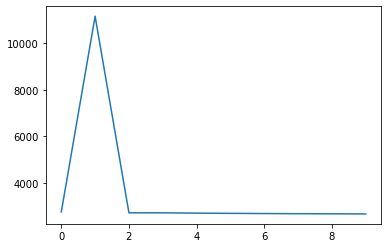

In [90]:
plt.plot(loss_list)

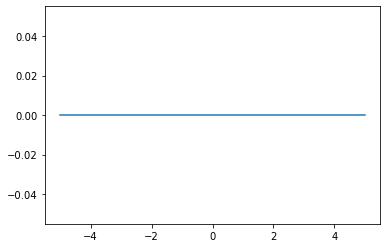

In [86]:
plt.plot(x,model(x))